In [40]:
!pip install shap -q

In [84]:
!pip install phik -q

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

In [3]:
path = 'https://stepik.org/media/attachments/lesson/779915/fs_task3_310f.csv'

df = pd.read_csv(path)
df.shape

(1636, 311)

In [4]:
df.sample(2)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,target
1483,-1.182,0.944,-0.80,0.017,-0.054,27067,-0.33,37897,1.08,0.58,...,41895,14465,-0.70,0.61,0.70,41128,-0.289,0.22,173,engine_overheat
966,-0.279,0.033,-0.31,1.515,-1.373,27956,0.01,16946,-1.33,-0.29,...,36318,23704,-0.39,-0.14,-0.35,24453,0.570,0.76,172,break_bug


In [22]:
tmp = df.describe().T
tmp['not_null%'] = (df.nunique() / df.shape[0]).round(2)
tmp.to_csv('describe.csv')

In [57]:
removed1 = tmp[(tmp['mean'].abs() < 0.09) & (tmp['std'].abs() < 1.09)].index.tolist()

In [59]:
selected1 = [
    'feature_59', 'feature_141', 'feature_203', 'feature_243', 'feature_309', 'feature_132', 'feature_270'
    # 'feature_201', 'feature_269'
]

In [64]:
df = df.drop(removed1, axis=1)

In [6]:
target = 'target'

### EDA

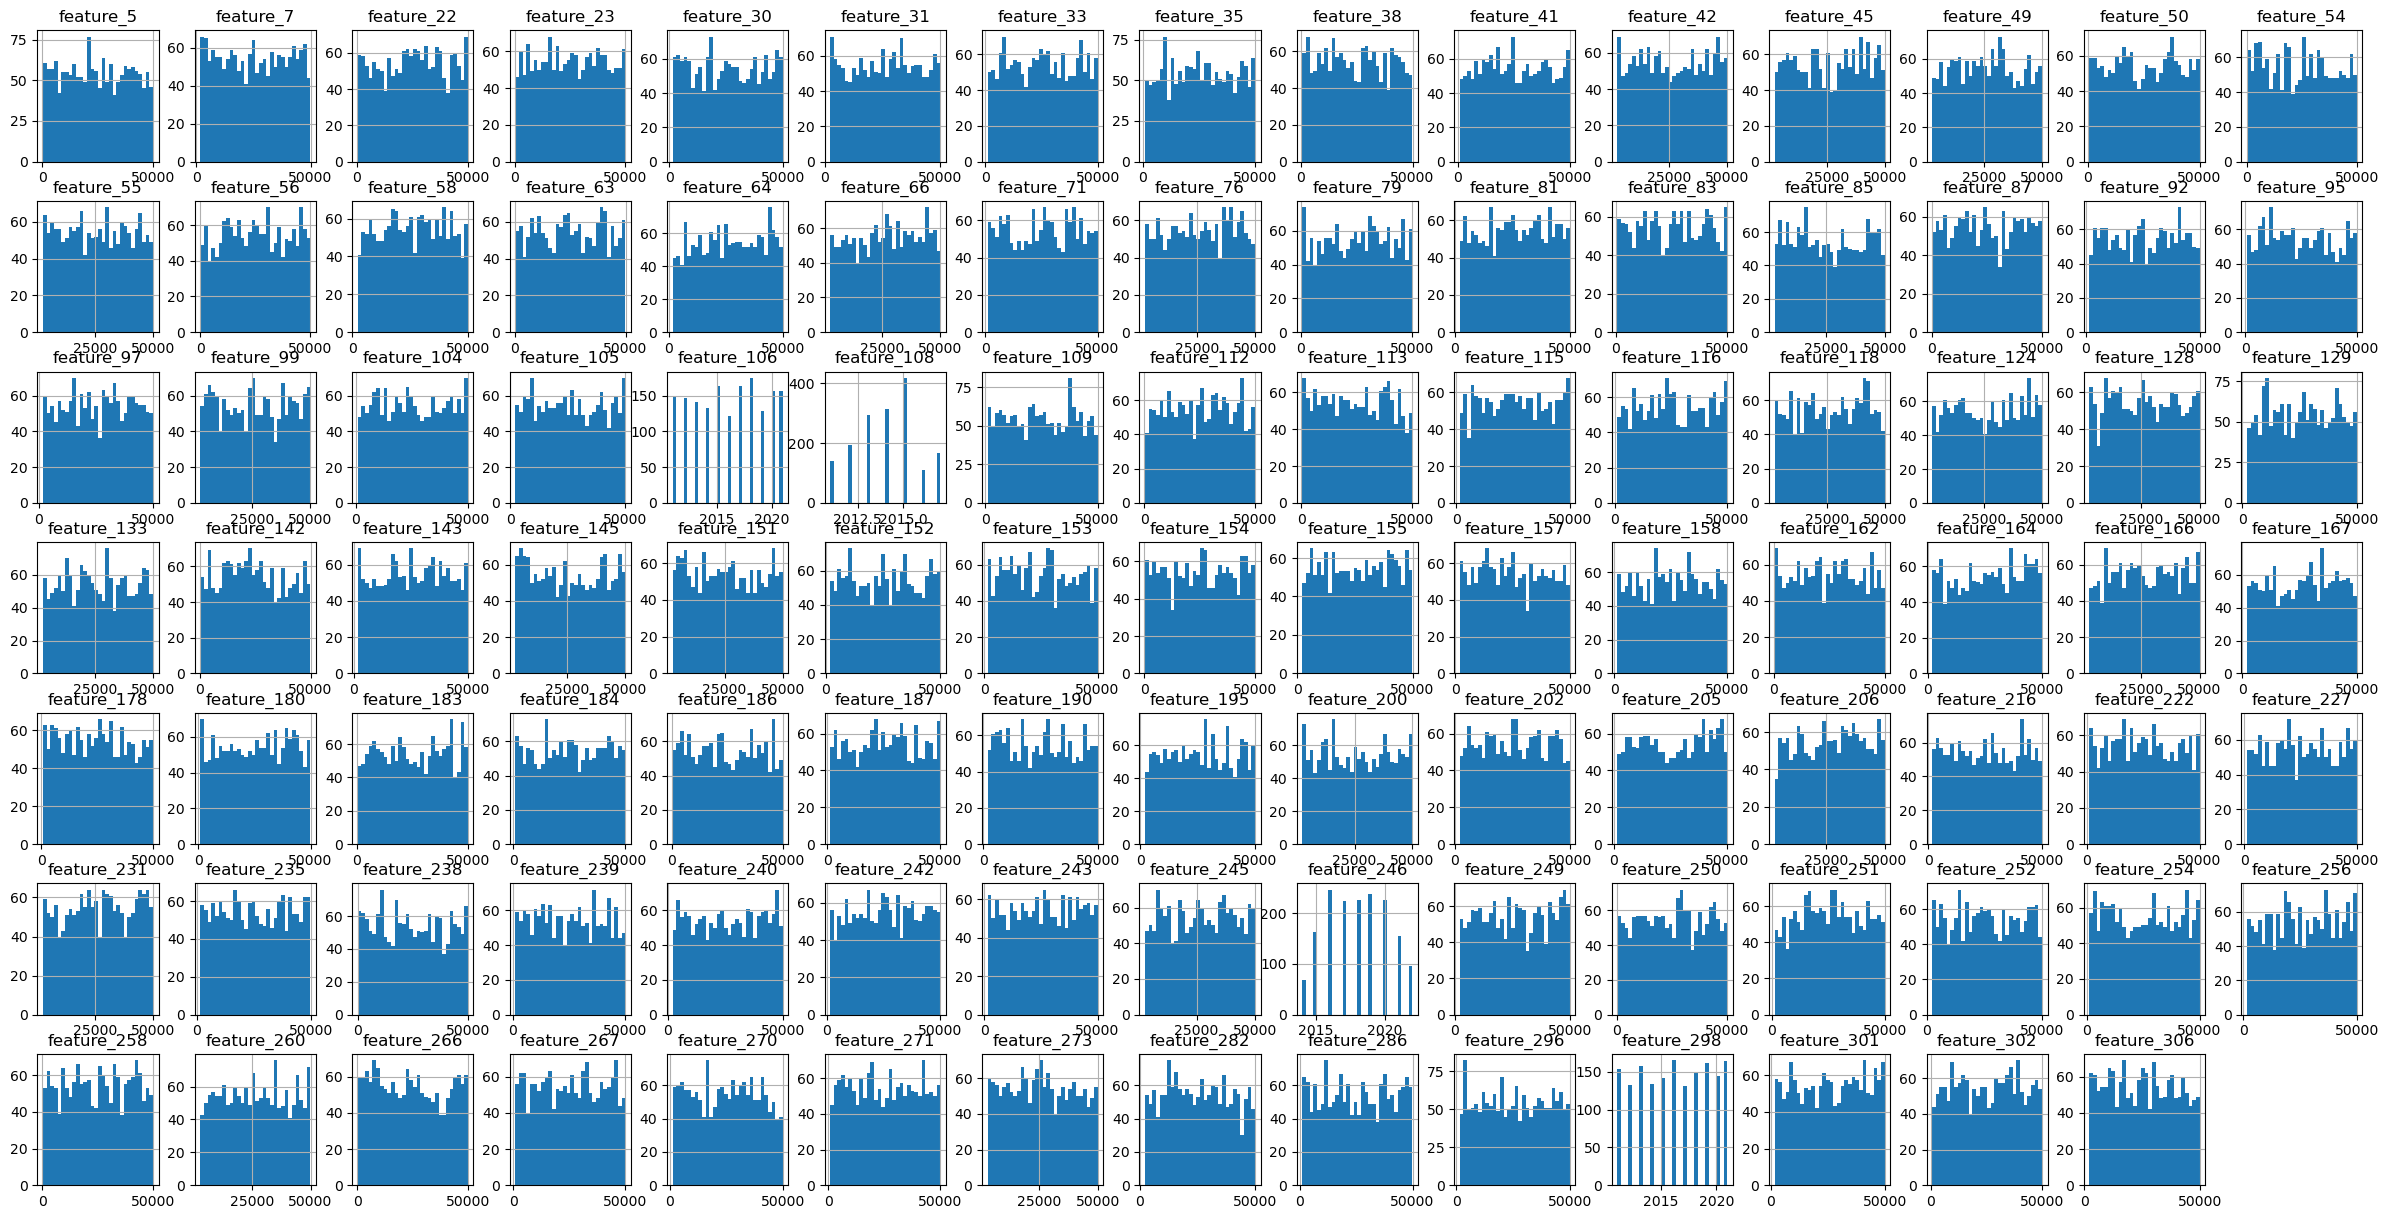

In [96]:
df[other].hist(figsize=(10 * 3, 5 * 3), layout=(-1, 15), bins=30);
plt.savefig('distr.pdf')

### corr

In [48]:
# corrs = df.dropna().corr(numeric_only=True).round(3)# .sort_values(target)
# sns.heatmap(corrs,
#             cmap = 'Greens',
#             square=True,
#             vmin = 0,
#            )


In [94]:
selected2 = [
    'feature_59', 'feature_141', 'feature_203', 'feature_234', 'feature_309', 
    'feature_132', 'feature_274', 'feature_127'
]

In [97]:
check1 = ['feature_106', 'feature_108', 'feature_246', 'feature_298']

In [95]:
other = [i for i in df.columns if i not in selected2]

### phik corr

interval columns not set, guessing: ['feature_106', 'feature_108', 'feature_246', 'feature_298']


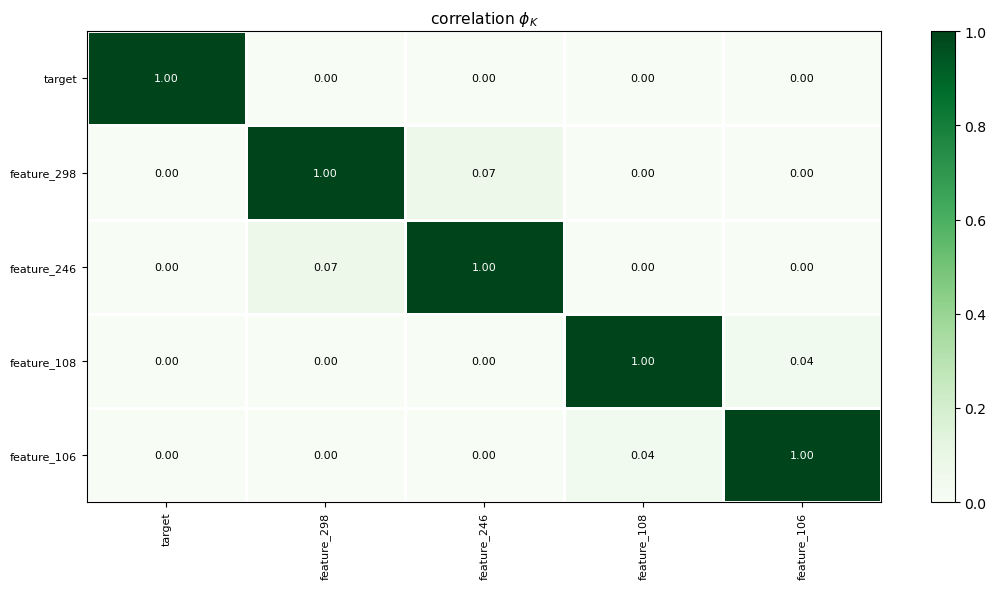

In [98]:
phik_overview = df[check1 + [target]].phik_matrix().round(2).sort_values(target)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [ ]:
phik_overview.sort_values(target)['target'].hist()

In [90]:
# significance_overview = df[other].significance_matrix().fillna(0).round(1).sort_values(target)

# plot_correlation_matrix(significance_overview.values, 
#                         x_labels=significance_overview.columns, 
#                         y_labels=significance_overview.index, 
#                         vmin=0, vmax=1, color_map="Greens",
#                         title="Significance of the coefficients", 
#                         usetex=False, fontsize_factor=0.8, figsize=(11, 6))
# plt.tight_layout()

In [ ]:
significance_overview.loc[target].sort_values()[:5]

In [92]:
significance_overview.loc['target_reg'].sort_values()[:5]

feature_9    -1.4
random_cat   -0.5
feature_4    -0.5
feature_5    -0.5
feature_19   -0.3
Name: target_reg, dtype: float64

### pair plot

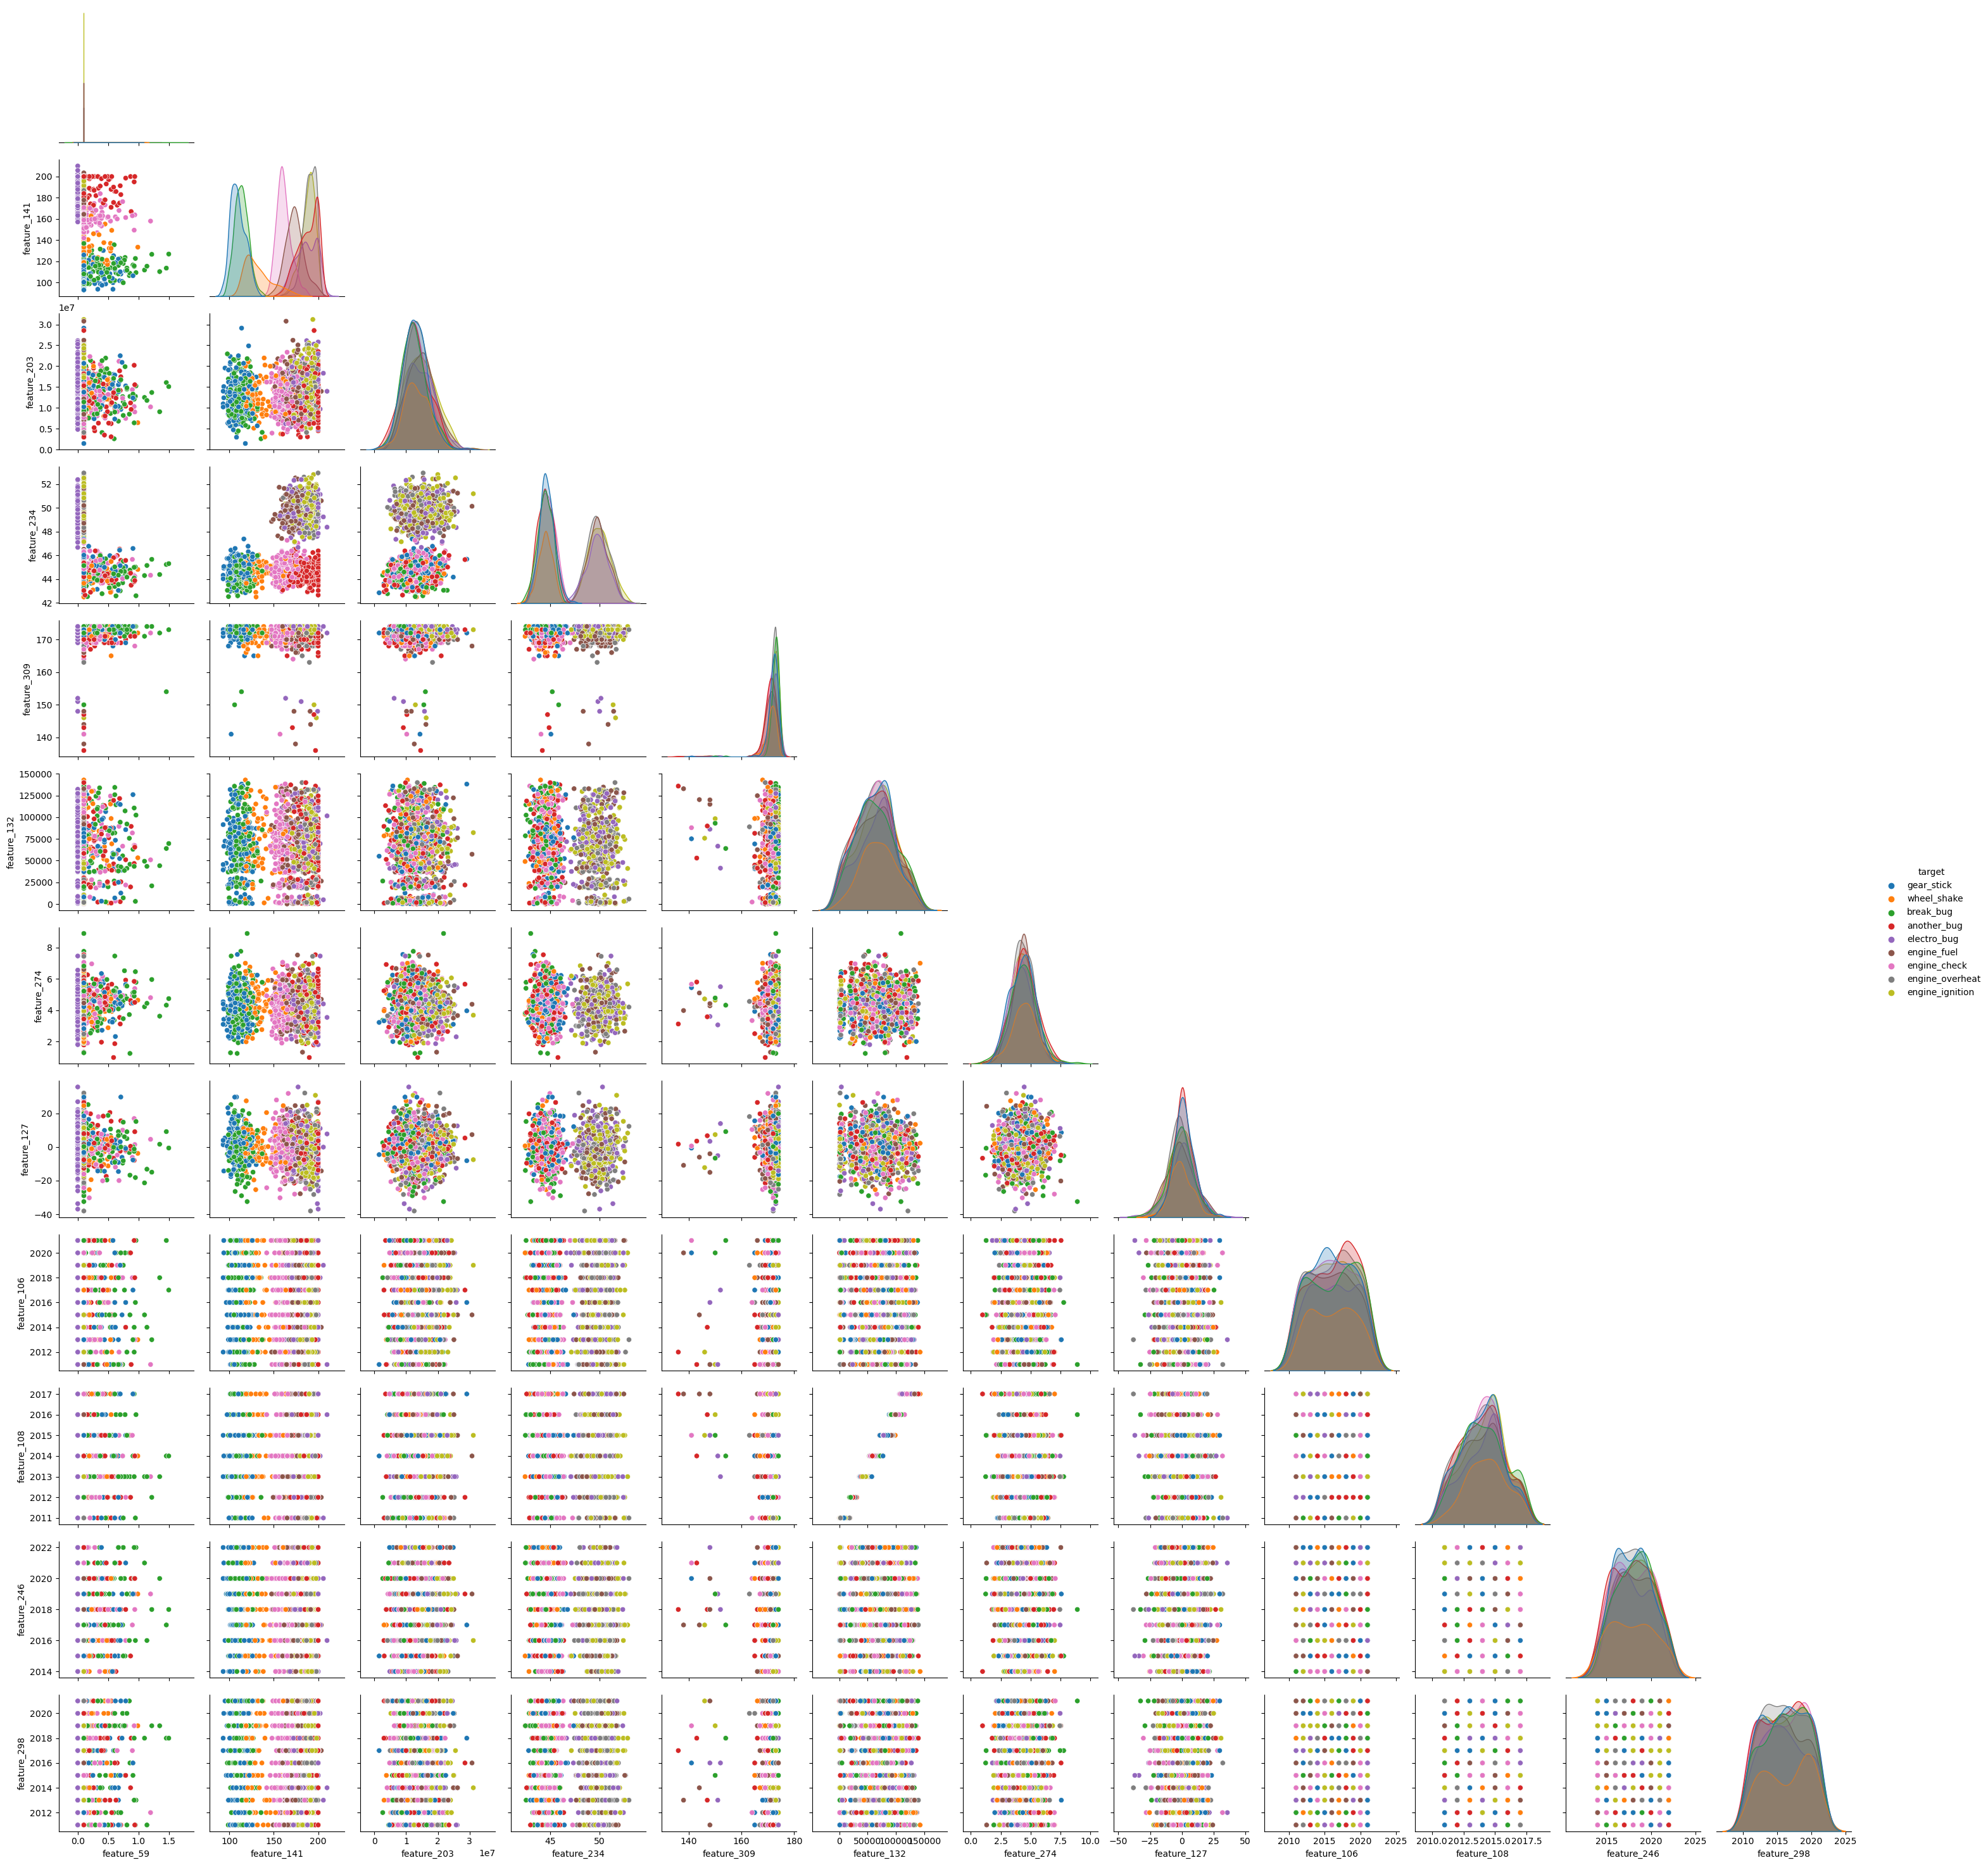

In [99]:
sns.pairplot(
    df[selected2 + check1 + [target]],
    corner=True,
    hue=target,
);

### Add random

In [81]:
# df['random_int'] = np.random.randint(-20, 200, df.shape[0]) # Целочисленный признак
# df['random_num'] = np.random.random(size = df.shape[0]) # Признак типа float с равномерным распределением
df['random_norm'] = np.random.normal(loc = 4, scale = 1.5, size = df.shape[0]) # Признак с нормальным распределением
df['random_cat'] = np.random.choice(['A', 'B', 'C', 'D'], p = [0.20, 0.3, 0.45, 0.05], size = df.shape[0]) # Категориальный признак str формата с дисбалансом
# df['random_ord'] = np.random.choice([1, 10, 100, 1000], p = [0.40, 0.3, 0.2, 0.1], size = df.shape[0]) # Численный категориальный признак


### Catboost feature importance

In [110]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split

In [126]:
drop_cols = ['target_reg',  'target_class',]
cat_cols = ['feature_0',
 'feature_2',
 'feature_3',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_12',
 'feature_14',
 'feature_16',
 'feature_17',
 'feature_18',
 'random_cat'
           ]

X = df.drop(drop_cols, axis=1)
y = df['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1)
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.10885
0:	learn: 1.8738953	test: 1.8562170	best: 1.8562170 (0)	total: 100ms	remaining: 1m 40s
100:	learn: 0.4309990	test: 0.5383508	best: 0.5383508 (100)	total: 9.07s	remaining: 1m 20s
200:	learn: 0.2962923	test: 0.5301227	best: 0.5255195 (133)	total: 19.6s	remaining: 1m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5255194785
bestIteration = 133

Shrink model to first 134 iterations.


In [128]:
# посмотрим на важность признаков катбуста
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,feature_13,37.507460
1,feature_1,30.718604
2,feature_15,14.600534
3,feature_2,3.919006
4,feature_18,2.459948
5,feature_12,2.342307
6,feature_14,1.807878
7,random_cat,1.487220
8,feature_4,0.970473
9,feature_16,0.768347


### Sklearn permutation_importance

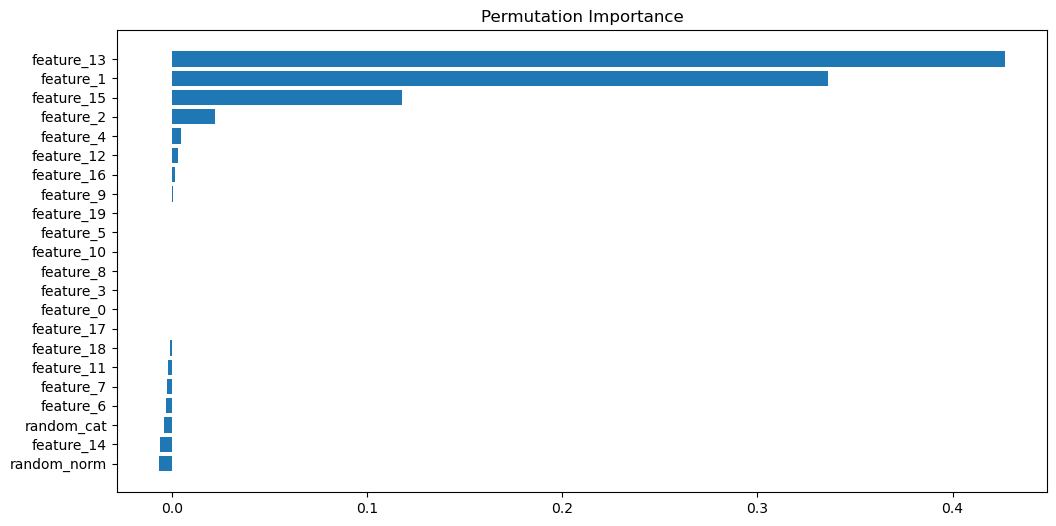

In [129]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

### Shap values

In [130]:
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols, feature_names=X_test.columns.tolist())
shap_values = explainer(val_dataset)

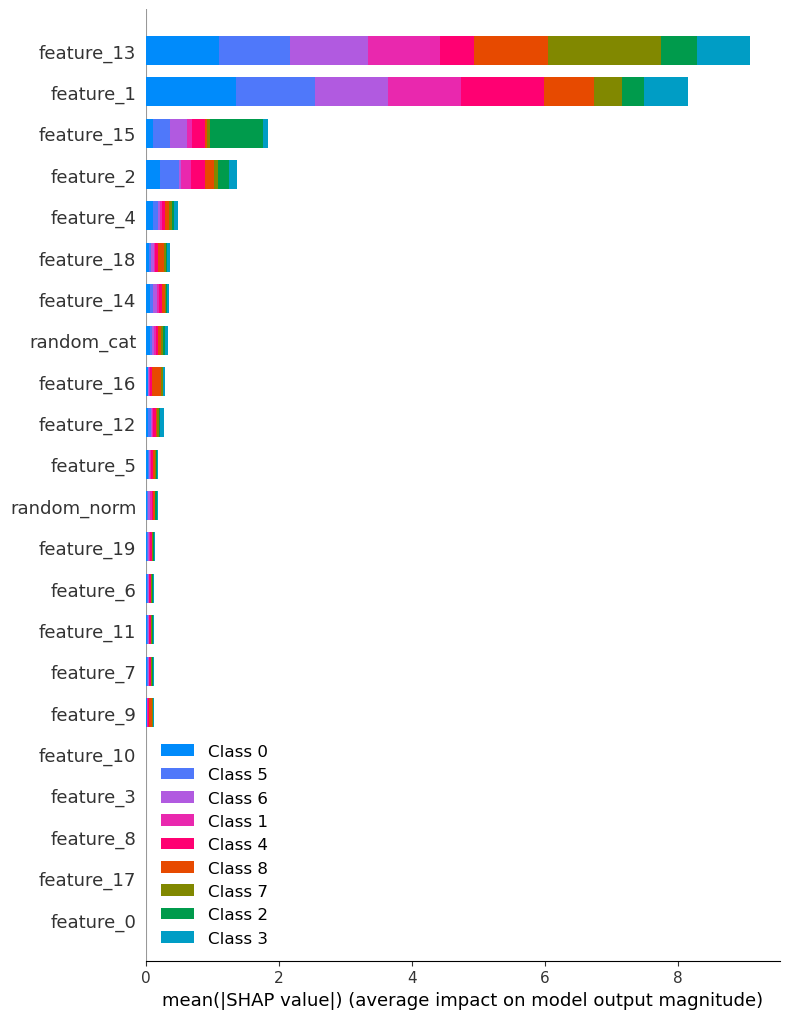

In [131]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, max_display=22);